16.04.21
Frame-by-frame classification
=======================================================

* Having a collection of videos with pre-defined "true" categories and a pretrained classifier:
    1. extract each frame of each video;
    2. perform a classification of each individual frame;
    3. extract the **per-frame accuracies** for the true category.
* Frame extractor variants:
    * [decord](https://github.com/dmlc/decord) [implemented]:
        ```
        vr = decord.VideoReader()
        frame_id_list = range(start, stop, pace)
        video_frames = vr.get_batch(frame_id_list).asnumpy()
        ```
    * [OpenCV](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html) [TODO]
 

# Moments in Time videos

In [ ]:
%%bash
unameOut="$(uname -s)"
case "${unameOut}" in
    Linux*)     machine=Linux;;
    Darwin*)    machine=Mac;;
    CYGWIN*)    machine=Cygwin;;
    MINGW*)     machine=MinGw;;
    *)          machine="UNKNOWN:${unameOut}"
esac

if [ ${machine} == 'Linux' ]
then
    pip install --upgrade decord
else
    echo "Install decord following the steps in https://github.com/dmlc/decord#mac-os"
fi

Clone the [frame-by-frame](https://github.com/CogNeuroUR/frame-by-frame) repo:

In [ ]:
!git clone https://github.com/CogNeuroUR/frame-by-frame.git

Cloning into 'frame-by-frame'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 80 (delta 6), reused 49 (delta 3), pack-reused 25
Unpacking objects: 100% (80/80), done.


In [1]:
# Imports
import os
from decord import VideoReader
from decord import cpu #, gpu
import decord
decord.bridge.set_bridge('native') # Seems to be the fastest option
#decord.bridge.set_bridge('torch') # or 'tensorflow', or 'mxnet'

from pathlib import Path

## Frame-by-frame classification

### ResNet50-MiT (torch)

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.nn import functional as F

from PIL import Image
from os import listdir
from os.path import isfile, join

import numpy as np
from random import sample, randint
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#path_prefix = Path().absolute() / 'frame-by-frame' # uncomment if on Colab
path_prefix = Path('..')

** w/ CUDA or NOT ? **

In [3]:
with_cuda = False

In [5]:
if with_cuda:
    resnet50 = models.resnet50(pretrained=False, progress=True, num_classes=339).to('cuda')
else:
    resnet50 = models.resnet50(pretrained=False, progress=True, num_classes=339)

[Down]-load MiT-pretrained model:

In [6]:
path_model = path_prefix / 'models/resnet50_moments-fd0c4436.pth'
print(path_model)

../models/resnet50_moments-fd0c4436.pth


In [7]:
#!curl http://moments.csail.mit.edu/moments_models/resnet50_moments-fd0c4436.pth --output models/resnet50_moments-fd0c4436.pth
path_model = path_prefix / 'models/resnet50_moments-fd0c4436.pth'
resnet50_moments = resnet50
resnet50_moments.load_state_dict(torch.load(path_model))
resnet50_moments.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
transformation = transforms.Compose([
                                     transforms.ToPILImage(mode='RGB'), # required if the input image is a nd.array
                                     transforms.Resize(224), # To be changed to rescale to keep the aspect ration?
                                     transforms.CenterCrop((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])
])

In [9]:
#!curl https://raw.githubusercontent.com/vrabiutz/my_images/master/category_momentsv1.txt --output category_momentsv1.txt
def load_categories():
    """Load categories."""
    with open(path_prefix / 'labels/category_momentsv1.txt') as f:
        return [line.rstrip() for line in f.readlines()]

# load categories
categories = load_categories()

##### Single video test

In [30]:
# Load video
print(os.getcwd())
video_fname = str(path_prefix / 'data/test/abseiling_k400.mp4')
vr = VideoReader(video_fname)#, ctx=cpu(0))
print('video frames:', len(vr))

/Users/vrabiutz/CogNeuroUR/Repositories/frame-by-frame/scripts
video frames: 250


Accuracy test (single frame)

torch.Size([3, 224, 224])


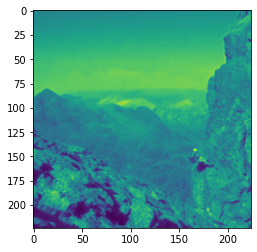

--Top Actions:
0.605 -> hiking
0.267 -> climbing
0.023 -> ascending
0.017 -> jumping
0.016 -> descending


In [31]:
# Accuracy test
video_frames = vr.get_batch([i for i in range(len(vr))])
img = video_frames.asnumpy()[randint(0, len(vr))]

# Image transformation
if with_cuda:
    t_img = transformation(img).to('cuda')
else:
    t_img = transformation(img)
print(t_img.shape)

plt.imshow(t_img[0].cpu())
plt.show()

# Classification:
logit = resnet50_moments.forward(t_img.unsqueeze(0))
h_x = F.softmax(logit, 1).data.squeeze()
probs, idx = h_x.sort(0, True)

#print(img_url)
# output the prediction of action category
print('--Top Actions:')
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], categories[idx[i]]))

Accuracy test (multiple frames)



0th frame:


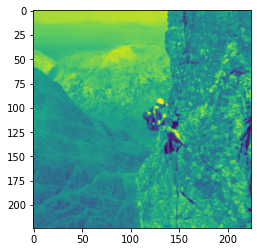

--Top Actions:
0.357 -> climbing
0.177 -> jumping
0.120 -> ascending
0.108 -> descending
0.070 -> hiking


20th frame:


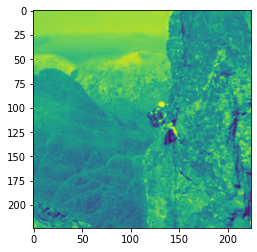

--Top Actions:
0.711 -> climbing
0.081 -> hiking
0.077 -> ascending
0.060 -> descending
0.027 -> jumping


40th frame:


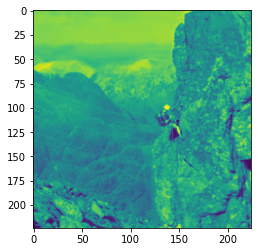

--Top Actions:
0.760 -> climbing
0.077 -> hiking
0.056 -> ascending
0.039 -> descending
0.031 -> jumping


60th frame:


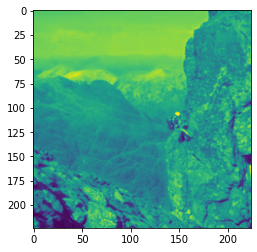

--Top Actions:
0.790 -> climbing
0.071 -> hiking
0.052 -> ascending
0.035 -> descending
0.018 -> jumping


80th frame:


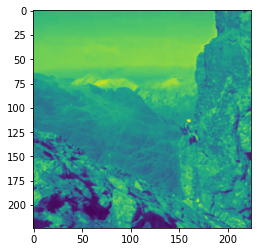

--Top Actions:
0.660 -> climbing
0.143 -> hiking
0.071 -> ascending
0.041 -> descending
0.029 -> jumping


100th frame:


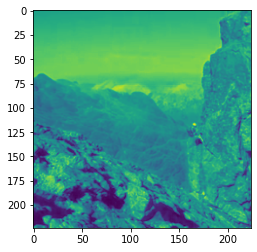

--Top Actions:
0.558 -> climbing
0.321 -> hiking
0.039 -> ascending
0.028 -> descending
0.014 -> jumping


120th frame:


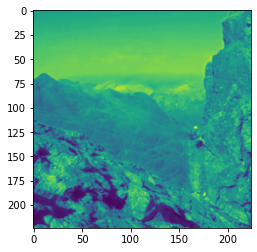

--Top Actions:
0.492 -> climbing
0.382 -> hiking
0.039 -> ascending
0.028 -> descending
0.013 -> bicycling


140th frame:


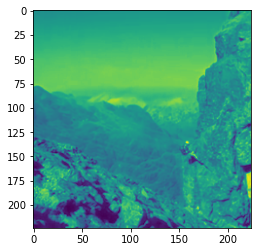

--Top Actions:
0.446 -> hiking
0.314 -> climbing
0.064 -> diving
0.056 -> jumping
0.038 -> ascending


160th frame:


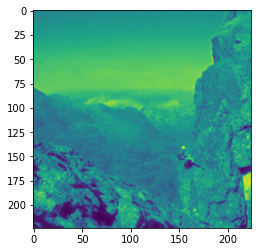

--Top Actions:
0.513 -> climbing
0.384 -> hiking
0.022 -> diving
0.018 -> jumping
0.018 -> ascending


180th frame:


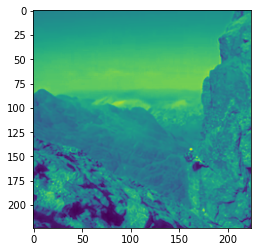

--Top Actions:
0.474 -> hiking
0.417 -> climbing
0.023 -> ascending
0.015 -> descending
0.014 -> diving


200th frame:


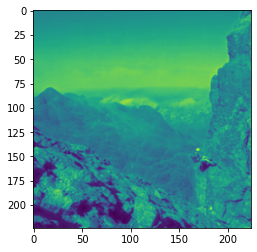

--Top Actions:
0.704 -> hiking
0.219 -> climbing
0.016 -> ascending
0.011 -> descending
0.008 -> jumping


220th frame:


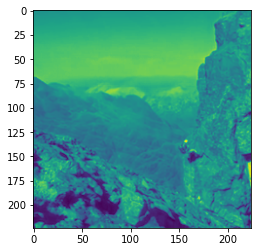

--Top Actions:
0.579 -> hiking
0.303 -> climbing
0.022 -> jumping
0.022 -> ascending
0.013 -> descending


240th frame:


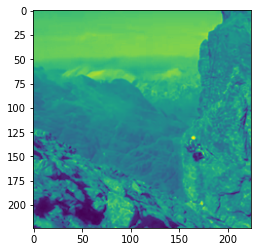

--Top Actions:
0.492 -> hiking
0.428 -> climbing
0.021 -> ascending
0.013 -> descending
0.010 -> bicycling


In [36]:
pred_accuracies = []
true_category = 'climbing'

for i in range(video_frames.shape[0]):
    frame = video_frames.asnumpy()[i]

    if with_cuda:
        input = transformation(frame).to('cuda')
    else:
        input = transformation(frame)
    
    # Classification:
    logit = resnet50_moments.forward(input.unsqueeze(0))
    h_x = F.softmax(logit, 1).data.squeeze()
    probs, idx = h_x.sort(0, True)

    # At each 20th frame, make a plot and print the top 5 categories with
    # the corresponding accuracy
    if i % 20 == 0:
        print(f'\n\n{i}th frame:')
        plt.imshow(input[0].cpu())
        plt.show()
        print('--Top Actions:')
        for i in range(0, 5):
            print('{:.3f} -> {}'.format(probs[i], categories[idx[i]]))
        
    pred_accuracies.append(probs.cpu()[[i for i in range(len(categories)) if categories[idx[i]]==true_category]])

Plot prediction accuracies for the true category across frames

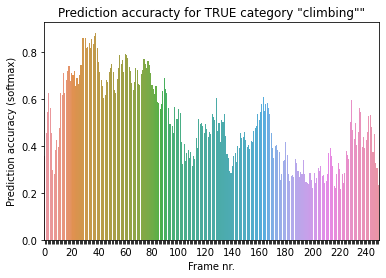

In [37]:
ax = sns.barplot(data=pred_accuracies)
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 20 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
ax.set_title(f'Prediction accuracty for TRUE category \"{true_category}\""')
ax.set_xlabel('Frame nr.')
ax.set_ylabel('Prediction accuracy (softmax)')

plt.show()

##### Multi-video frame extraction

-----------------

Go through each folder of the `MIT_sampleVideos_RAW` (or any other video dataset) and
* Collect the names of all video files per category and their path in the dataset
* Iterate over the videos of that category AND extract the frame-by-frame accuracy

Collect paths to files per category in a dictionary of structure:
```
{
    category_i : {
        video_j : path_to_video_j
    }
}
```

In [10]:
import os

path_videoset = path_prefix / 'data/MIT_sampleVideos_RAW_final_25FPS/'

d_files_per_category = {}

# Iterate over categories in path_prefix
for root, dirs, files in os.walk(path_videoset, topdown=False):
    for name in sorted(dirs):
        category_path = os.path.join(root, name)
        category_name = category_path.split('/')[-1]

        # Iterate over files in cateogory_path
        d_files_per_category[category_name] = {}
        for root2, dirs2, videos  in os.walk(category_path, topdown=False):
            for video in sorted(videos):
                video_fname = os.path.join(root2, video)
                
                d_files_per_category[category_name][video] = video_fname


In [11]:
d_files_per_category['aiming']

{'yt-0gwUV4Ze-Hs_390.mp4': '../data/MIT_sampleVideos_RAW_final_25FPS/aiming/yt-0gwUV4Ze-Hs_390.mp4',
 'yt-0qYbATyHm2A_59.mp4': '../data/MIT_sampleVideos_RAW_final_25FPS/aiming/yt-0qYbATyHm2A_59.mp4',
 'yt-2yYb3iQCivw_130.mp4': '../data/MIT_sampleVideos_RAW_final_25FPS/aiming/yt-2yYb3iQCivw_130.mp4',
 'yt-chT_6aIyhD4_47.mp4': '../data/MIT_sampleVideos_RAW_final_25FPS/aiming/yt-chT_6aIyhD4_47.mp4',
 'yt-fG9wZzs4jis_124.mp4': '../data/MIT_sampleVideos_RAW_final_25FPS/aiming/yt-fG9wZzs4jis_124.mp4',
 'yt-fM2iXUuaP7U_48.mp4': '../data/MIT_sampleVideos_RAW_final_25FPS/aiming/yt-fM2iXUuaP7U_48.mp4',
 'yt-iVSy96zolvw_23.mp4': '../data/MIT_sampleVideos_RAW_final_25FPS/aiming/yt-iVSy96zolvw_23.mp4'}

Collect accuracies per file using the pre-trained model:

* Type #1: **values on true category ONLY**
    ```
    {
        category_i : {
            video_j : [list of per-frame accuracies on the true category]
        }
    }
    ```

* Type #2: **values on all categories**
    ```
    {
        category_i : {
            video_j : [list of per-frame accuracies for all categories]
        }
    }
    ```

In [15]:
import time
from torch.nn import functional as F

accuracies_per_category = {}
z = 1 # For verbose

# Iterate over categories in path_prefix
for category_name in list(d_files_per_category.keys()):
    print(f'{category_name} {z}/{len(list(d_files_per_category.keys()))}'); z += 1
    
    # Define empty dictionary entry for current category
    accuracies_per_category[category_name] = {}

    # Iterate over files in cateogory_path
    for video in list(d_files_per_category[category_name]):
        # verbose
        print('\t', video)

        video_fname = d_files_per_category[category_name][video]
        
        # Load video with Decord.VideoReader
        vr = VideoReader(video_fname, ctx=cpu(0))
        frame_id_list = range(0, len(vr), 1)
        video_frames = vr.get_batch(frame_id_list)

        pred_accuracies = []
        true_category = category_name

        start_time = time.time()
        # Iterate through frames
        for i in range(video_frames.shape[0]):
            # Load frame
            frame = video_frames.asnumpy()[i]

            # Transform
            if with_cuda:
                input = transformation(frame).to('cuda')
            else:
                input = transformation(frame)
            
            # Classification:
            logit = resnet50_moments.forward(input.unsqueeze(0))
            h_x = F.softmax(logit, 1).data.squeeze()
            probs, idx = h_x.sort(0, True)

            """
            # Save accuracies for the TRUE category/class ONLY (TYPE #1)
            pred_accuracies.append(probs.cpu().numpy()[[i for i in range(len(categories)) if categories[idx[i]]==category_name]])
            """
            
            # Save accuracies for the all classes (TYPE #2)
            pred_accuracies.append(probs.cpu().numpy())
        
        # Calculate avg duration per frame
        end_time = time.time()
        print('\tAvg duration per frame: %4.4f seconds.' % ((end_time - start_time)/(video_frames.shape[0])))
        
        # Add computed list of accuracies as entry in the output dictionary
        accuracies_per_category[category_name][video] = pred_accuracies

.
	 yt-_mtyKXigOms_265.mp4
	Avg duration per frame: 0.0292 seconds.
	 yt-_osYq8b4low_435.mp4
	Avg duration per frame: 0.0291 seconds.
stitching 236/278
	 vine-LIVE-LLBean-Boat-and-Tote-stitching-at-AmericanField-Boston-h66EjVgrYtU_2.mp4
	Avg duration per frame: 0.0208 seconds.
	 vine-Stitching-hHqTuZ6mOaA_1.mp4
	Avg duration per frame: 0.0207 seconds.
	 vine-Turtle-Island-Moccasins-operating-his-custom-Pfaff-adjusted-to-treadle-stitching-h6HiLFOeIZO_2.mp4
	Avg duration per frame: 0.0208 seconds.
	 vine-We-made-me-a-shirt-crafting-Kirstin-M2gmXEj6pVq_2.mp4
	Avg duration per frame: 0.0208 seconds.
	 vine-season-1-episode-2-top-stitching-with-han-gen-MZHxObhaTA9_2.mp4
	Avg duration per frame: 0.0208 seconds.
	 vine-season-1-episode-4-back-stitching-MZH2YTabJdT_2.mp4
	Avg duration per frame: 0.0208 seconds.
	 yt-_1Y2p4bSwyA_144.mp4
	Avg duration per frame: 0.0292 seconds.
	 yt-_3NTh-D3m64_336.mp4
	Avg duration per frame: 0.0292 seconds.
	 yt-_EH8an2hKUI_838.mp4
	Avg duration per frame: 0.0

Save dictionary to pickle file

In [19]:
# Save dictionary to pickle file
import pickle
dict_path = path_prefix / 'saved/accuracies_per_category_mitv1_fps-25.pkl'

if dict_path.is_file():
    print(f'File {dict_path} already exists. Change dict_path and re-run cell!')
else:
    with open(dict_path, 'wb') as f:
        pickle.dump(accuracies_per_category, f)
        f.close()
    print(f'Saved at {dict_path.absolute()}')

Saved at /Users/vrabiutz/CogNeuroUR/Repositories/frame-by-frame/scripts/../saved/accuracies_per_category_mitv1_fps-25.pkl


Load dictionary from file:

In [5]:
import pickle
dict_path = path_prefix / 'saved/accuracies_per_category_mitv1.pkl'
f = open(dict_path, 'rb')
accuracies_per_category = pickle.load(f)

In [6]:
accuracies_per_category['aiming'].keys()

dict_keys(['yt-0gwUV4Ze-Hs_390.mp4', 'yt-0qYbATyHm2A_59.mp4', 'yt-2yYb3iQCivw_130.mp4', 'yt-chT_6aIyhD4_47.mp4', 'yt-fG9wZzs4jis_124.mp4', 'yt-fM2iXUuaP7U_48.mp4', 'yt-iVSy96zolvw_23.mp4'])

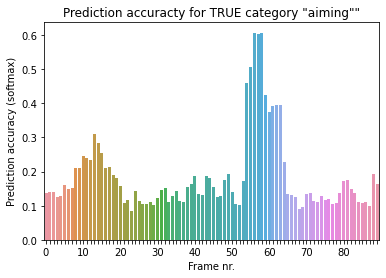

In [23]:
import seaborn as sns
ax = sns.barplot(data=accuracies_per_category['aiming']['yt-0gwUV4Ze-Hs_390.mp4'])
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
ax.set_title(f'Prediction accuracty for TRUE category \"{true_category}\""')
ax.set_xlabel('Frame nr.')
ax.set_ylabel('Prediction accuracy (softmax)')

plt.show()

Plot best and worst frame

In [7]:
c_name = 'aiming'
f_name = 'yt-0gwUV4Ze-Hs_390.mp4'

path_2_file = path_prefix / f'data/MIT_sampleVideos_RAW/{c_name}/{f_name}'
vr = VideoReader(str(path_2_file))

sns.set_style("whitegrid", {'grid.linestyle': '--'})

plt.figure(figsize=(20, 10))

ax1 = plt.subplot(212)
#ax1.margins(0.05)          
ax1 = sns.barplot(data=accuracies_per_category[c_name][f_name])
ax1.set_title('Per-frame accuracies')
ax1.set_xlabel('Frame nr.')
ax1.set_ylabel('Prediction accuracy (softmax)')

worst_frame = vr.get_batch(np.argmin(accuracies_per_category[c_name][f_name]))
ax2 = plt.subplot(221)
#ax2.margins(2, 2)           
ax2.imshow(worst_frame.asnumpy()[0])
ax2.set_title('Worst frame')

best_frame = vr.get_batch(np.argmax(accuracies_per_category[c_name][f_name]))
ax3 = plt.subplot(222)
#ax3.margins(x=0, y=-0.25)  
ax3.imshow(best_frame.asnumpy()[0])
ax3.set_title('Best frame')

plt.show()